In [2]:
from tkinter.tix import MAX
from textPreprocessing import Preprocessing
from transformers import AutoTokenizer, AutoModel
from typing import List
from keras.preprocessing.sequence import pad_sequences
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import numpy as np
from sklearn.manifold import TSNE


def create_ids(text: str) -> List[int]:
    # encode text
    return tokenizer.encode(text)   #add_special_tokens: bool = True

def convert_to_tokens(input_ids: List[int]) -> List[str]:
    return tokenizer.convert_ids_to_tokens(input_ids, skip_special_tokens=False)


tokenizer = AutoTokenizer.from_pretrained("nlpaueb/bert-base-greek-uncased-v1")
model = AutoModel.from_pretrained("nlpaueb/bert-base-greek-uncased-v1", output_hidden_states = True)

model.eval()

sentences = Preprocessing.separate_to_sentences("./txt_files/text_delta/text_delta.txt")
with open("./txt_files/text_delta/edited_text.txt", "w") as file:
    file.write(Preprocessing.strip_accents_and_lowercase(sentences))

input_ids = []
with open("./txt_files/text_delta/edited_text.txt", "r") as text:
    for line in text.readlines():
        input_ids.append(create_ids(line))


MAX_LEN = max([len(sen) for sen in input_ids])

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

# Create attention masks
attention_masks = []

# For each sentence...
for sent in input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

# print(len(input_ids))

# Convert to tensors.
inputs_tensor = torch.tensor(input_ids)
att_tensor = torch.tensor(attention_masks)

# Predict hidden states features for each layer
with torch.no_grad():
    outputs = model(inputs_tensor,att_tensor)


hidden_states = outputs[2]    #because of output_hidden_states = True

print ("Number of layers:", len(hidden_states), "  (initial embeddings + 12 BERT layers)")
layer_i = 0
print ("Number of batches:", len(hidden_states[layer_i]))
batch_i = 0
print ("Number of tokens:", len(hidden_states[layer_i][batch_i]))
token_i = 0
print ("Number of hidden units:", len(hidden_states[layer_i][batch_i][token_i]))


all_tokens = []
for id in input_ids:
  all_tokens.append(convert_to_tokens(id))


# output_embeddings: there are punctuations' embeddings, 
#                    but not those of special tokens
special_tokens = tokenizer.special_tokens_map.values()

with open("./txt_files/text_delta/output_embeddings.txt", "w") as output:
  for x in range(0,len(hidden_states[12])):
    output.write(str(x+1) + " sentence \n")
    for y in range(0,len(all_tokens[x])):
        if all_tokens[x][y] not in special_tokens:
            output.write("%s: %s\n" %(all_tokens[x][y], hidden_states[12][x][y]))


2022-10-13 11:07:35.688146: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
Some weights of the model checkpoint at nlpaueb/bert-base-greek-uncased-v1 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from 


Padding/truncating all sentences to 96 values...

Padding token: "[PAD]", ID: 0
Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 49
Number of tokens: 96
Number of hidden units: 768


In [3]:
# convert to numpy.array
np_all = hidden_states[12].numpy()

# Check if np_all is right
# with open("check.txt", "w") as ch:
#     for i in range(0,2):
#         for j in range(0,96):
#             for z in range(0,768):
#                 ch.write(str(np_all[i][j][z]) + " ")
#             ch.write("\n")


new = np_all.reshape(len(hidden_states[12])*len(hidden_states[12][0]),len(hidden_states[12][0][0]))

# Check if np_all is right
# with open("check1.txt", "w") as ch:
#     for i in range(0,2*96):
#         for z in range(0,768):
#             ch.write(str(new[i][z]) + " ")
#         ch.write("\n")

# df_all contains all the word_embeddings of text [NoSentences*NoTokens x len_token]
df_all = pd.DataFrame(new)


In [40]:
# indexes of special tokens

indexes = []
for seq in range(0,len(all_tokens)):
  for c, v in enumerate(all_tokens[seq]):
      if v in special_tokens:
        indexes.append(len(all_tokens[seq])*seq + c)

2D Visualization with TSNE

/home/aaprokou/Apps/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/aaprokou/Apps/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/aaprokou/Apps/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/aaprokou/Apps/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be 

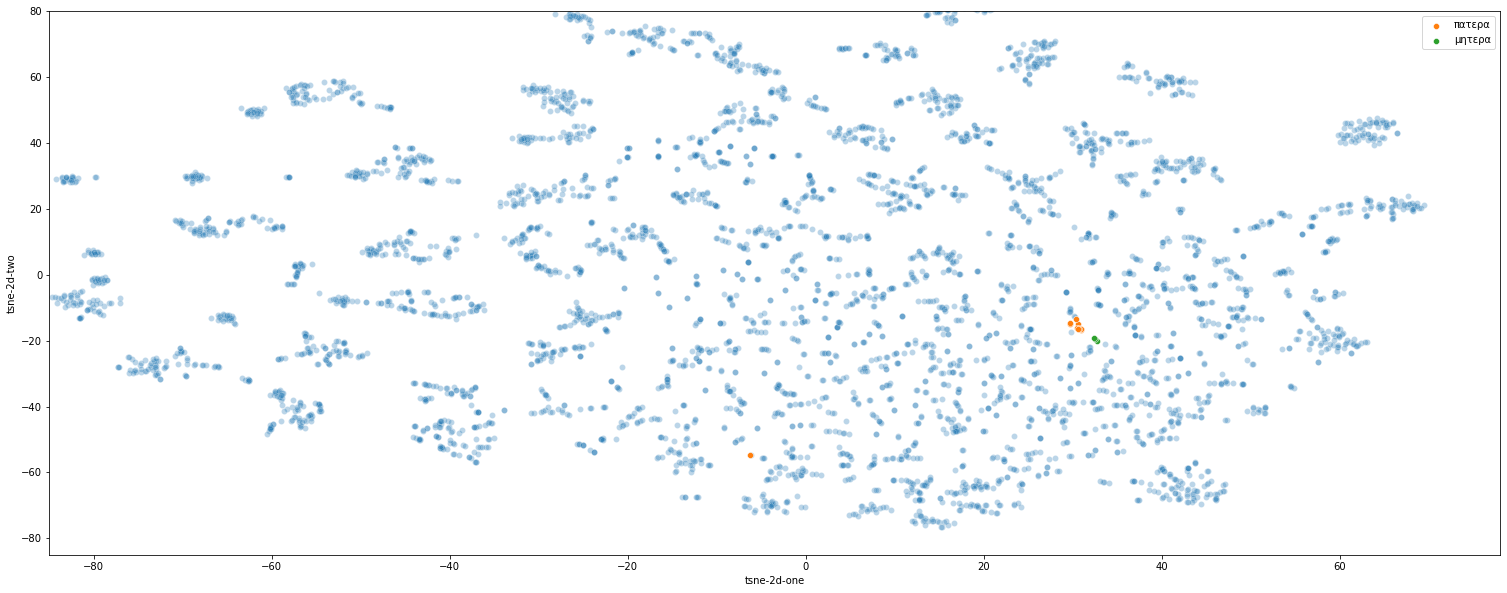

In [48]:
tsne = TSNE(n_components=2)

tsne_results = tsne.fit_transform(df_all)


plt.figure(figsize=(26,10))
plt.axis([-85, 78, -85, 80])

# Visualize specific token
token1 = "πατερα"
token2 = "μητερα"
indexes1 = []
indexes2 = []
for seq in range(0,len(all_tokens)):
  for c, v in enumerate(all_tokens[seq]):
      if token1 in v:    # str in v
        indexes1.append(len(all_tokens[seq])*seq + c)
        # labels.append([seq, c])
      if token2 in v:
        indexes2.append(len(all_tokens[seq])*seq + c)

x1,y1 = list(zip(*tsne_results[indexes1,:]))
x2,y2 = list(zip(*tsne_results[indexes2,:]))

# remove indexes1, indexes2 which correspond to words that we search 

# visualize special token ?
# 1. yes
res = np.delete(tsne_results, (indexes1+indexes2), axis=0)
# 2. no 
# res = np.delete(tsne_results, (indexes+indexes1+indexes2), axis=0)

d = {'tsne-2d-one': res[:,0], 'tsne-2d-two': res[:,1]}

# # visualize special token or not, choose 1. or 2. 
# # 1. 
# tsne_no_special_tokens = np.delete(tsne_results, indexes, axis=0)
# d = {'tsne-2d-one': tsne_no_special_tokens[:,0], 'tsne-2d-two': tsne_no_special_tokens[:,1]}
# # 2.

df = pd.DataFrame(d)

sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
    alpha=0.3
)

# plt.text(x=tsne_results[indexes,0]+0.3,y=tsne_results[indexes,1]+0.3, s=all_tokens[labels[:,0]][labels[:,1]])
sns.scatterplot(x1,y1, palette=sns.color_palette("Greens", 10),label=token1)  #orange
sns.scatterplot(x2,y2, palette=sns.color_palette("Blues", 10),label=token2)   #green

plt.show()

3D Visualization with TSNE

/home/aaprokou/Apps/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/aaprokou/Apps/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


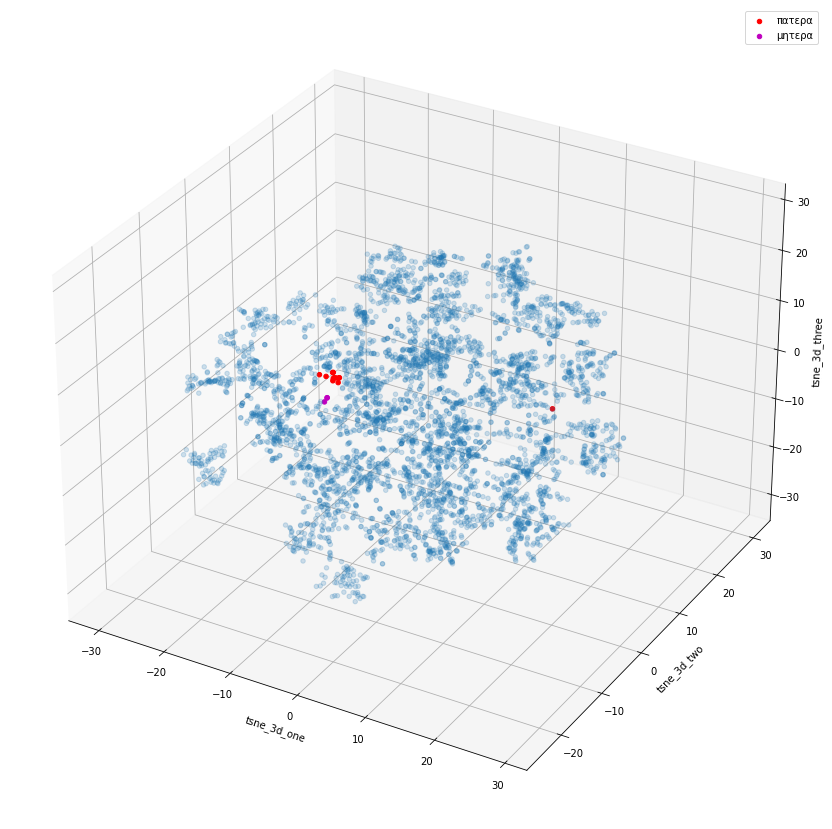

In [49]:
tsne_results = TSNE(n_components=3, random_state=0).fit_transform(df_all)

fig = plt.figure(figsize=(26,15))
ax = fig.add_subplot(111, projection = '3d')

x1,y1,z1 = list(zip(*tsne_results[indexes1,:]))
x2,y2,z2 = list(zip(*tsne_results[indexes2,:]))


# remove indexes1, indexes2 which correspond to words that we search 

# visualize special token ?
# 1. yes
res = np.delete(tsne_results, (indexes1+indexes2), axis=0)
# 2. no 
# res = np.delete(tsne_results, (indexes+indexes1+indexes2), axis=0)

x,y,z = list(zip(*res))

ax.scatter(x1,y1,z1, color='r', alpha=1, label=token1)
ax.scatter(x2,y2,z2, color='m', alpha=1, label=token2)
ax.scatter(x,y,z, alpha=0.2)

ax.set_xlabel('tsne_3d_one')
ax.set_ylabel('tsne_3d_two')
ax.set_zlabel('tsne_3d_three')

ax.legend([token1, token2])

# for angle in range(0,360): 
#     ax.view_init(40,angle)

# plt.show()


/home/aaprokou/Apps/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/aaprokou/Apps/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


96
96


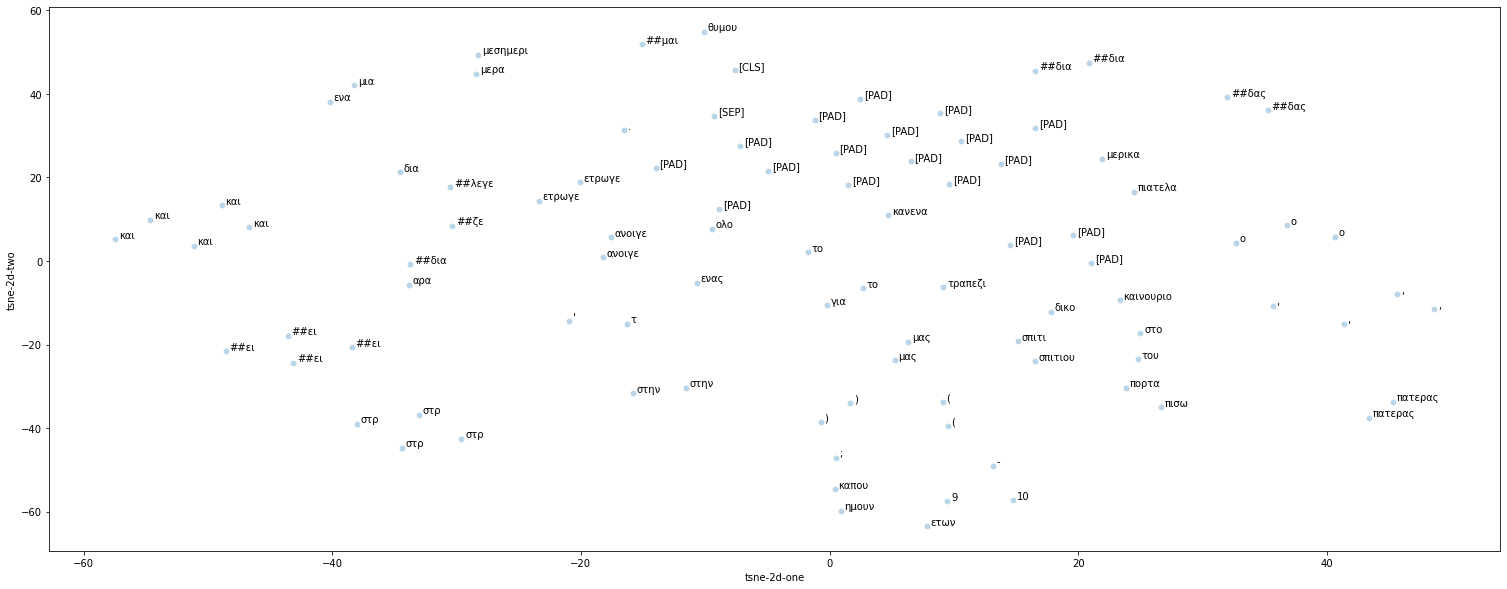

In [ ]:
# for one sentence 

tsne = TSNE(n_components=2)

df_seq = pd.DataFrame(columns=['tsne-2d-one', 'tsne-2d-two'])
# for seq in range(0,len(hidden_states[12][0])):
tsne_results = tsne.fit_transform(hidden_states[12][30])
d = {'tsne-2d-one': tsne_results[:,0], 'tsne-2d-two': tsne_results[:,1]}
df_seq = pd.DataFrame(d)
# print(df_seq)

plt.figure(figsize=(26,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    palette=sns.color_palette("hls", 10),
    data=df_seq,
    legend="full",
    alpha=0.3
)

print(tsne_results.shape[0])
print(len(all_tokens[0]))

for i in range(tsne_results.shape[0]):
    plt.text(x=tsne_results[i,0]+0.3,y=tsne_results[i,1]+0.3, s=all_tokens[30][i])

plt.show()